Epoch:0/1000 Error_train:1.0987021411538458 Error_test1.0987017084697623
Epoch:100/1000 Error_train:0.01825627463388438 Error_test0.0689010563518782
Epoch:200/1000 Error_train:0.00938936512730882 Error_test0.08116215861266614
Epoch:300/1000 Error_train:0.005246992502712456 Error_test0.08198717314059158
Epoch:400/1000 Error_train:0.004527877638712764 Error_test0.09873886904877635
Epoch:500/1000 Error_train:0.004172336553344758 Error_test0.09522865111700314
Epoch:600/1000 Error_train:0.0045145050638416215 Error_test0.10630537851416215
Epoch:700/1000 Error_train:0.0037716268274234797 Error_test0.10431047362202556
Epoch:800/1000 Error_train:0.0025991801398347033 Error_test0.11459316629581447
Epoch:900/1000 Error_train:0.0027492978575784158 Error_test0.10764469273788227


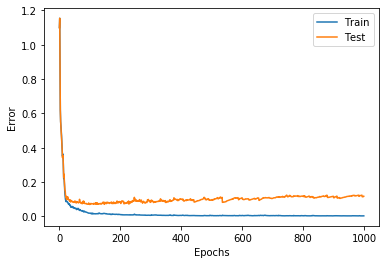

Accuracy Train: 100.0% Accuracy Test: 97.33333333333334%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

ave_input = np.average(input_data, axis = 0)
std_input = np.std(input_data, axis = 0)
input_data = (input_data - ave_input) / std_input

correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.01
eta = 0.1
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        self.h_w = np.zeros((n_upper, n)) + 1e-2
        self.h_b = np.zeros(n) + 1e-2
        
    def update(self, eta):
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        self.h_w += self.grad_w * self.grad_w
        self.h_b += self.grad_b * self.grad_b
        
#드롭아웃층 추가
class Dropout:
    #드롭아웃할 확률을 설정
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
        
    def forward(self, x, is_train):
        #입력뒤에 인수가 Ture값이 들어가면 드롭아웃층을 지나고 아니면 지나지 않도록 설정
        if is_train:
            #입력(뉴런수)와 같은 크기로 평균0, 표준편차1인 난수 생성
            rand = np.random.rand(*x.shape)
            #난수가 앞에 설정한 확률보다 높으면 뉴런이 생존, 낮으면 제거
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio)*x
            
    def backward(self, grad_y):
        #순전파에서 살아있는 뉴런만 역전파에 영향을 주게 설정
        self.grad_x = grad_y * self.dropout
        
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <=0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)
        
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis = 1, keepdims = True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)
        
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)
    
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

n_batch = n_train // batch_size
for i in range(epoch):
    
    forward_propagation(input_train,0)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test,0)
    error_test = get_error(correct_test, n_test)
    
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
             "Error_train:" + str(error_train),
             "Error_test" + str(error_test))
        
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    
    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        forward_propagation(x,True)
        backpropagation(t)
        
        uppdate_wb()
        
plt.plot(train_error_x, train_error_y, label = "Train")
plt.plot(test_error_x, test_error_y, label = "Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

forward_propagation(input_train,0)
count_train = np.sum(np.argmax(output_layer.y,
                    axis=1) == np.argmax(correct_train, axis =1))

forward_propagation(input_test, 0)
count_test = np.sum(np.argmax(output_layer.y,
                             axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")